In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, least_squares

# Q1

In [ ]:
def resolutionSystem1Euler(alpha,beta,delta,gamma,y0,z0,dt,N,t0=1900.0):
    "Cette fonctipn permet de resoudre le système (1)"
    temps = np.arange(0,N)*dt+t0 # si j'ai bien compris la question (dt=10/(N-1) pour 10 années)
    y = [y0]
    z = [z0]
    for i in range(N-1):
        y.append(y[i]+dt*y[i]*(alpha-beta*z[i]))
        z.append(z[i]+dt*z[i]*(delta*y[i]-gamma))

    return temps,np.array(y),np.array(z)

In [ ]:
def h(y,z,alpha,beta,delta,gamma) :

    return y*(alpha-beta*z),z*(delta*y-gamma)

In [ ]:
def resolutionSystem1EulerRK4(alpha,beta,delta,gamma,y0,z0,dt,N,t0=1900.0):
    "Cette fonctipn permet de resoudre le système (1)"
    temps = np.arange(0,N)*dt+t0 # si j'ai bien compris la question (dt=10/(N-1) pour 10 années)
    y = [y0]
    z = [z0]
    for i in range(N-1):
        k1 = h(y[i],z[i],alpha,beta,delta,gamma)
        k2 = h(y[i]+0.5*dt*k1[0],z[i]+0.5*dt*k1[1],alpha,beta,delta,gamma)
        k3 = h(y[i]+0.5*dt*k2[0],z[i]+0.5*dt*k2[1],alpha,beta,delta,gamma)
        k4 = h(y[i]+dt*k3[0],z[i]+dt*k3[1],alpha,beta,delta,gamma)
        y.append(y[i]+(dt/6)*(k1[0]+2*k2[0]+2*k3[0]+k4[0]))
        z.append(z[i]+(dt/6)*(k1[1]+2*k2[1]+2*k3[1]+k4[1]))

    return temps,y,z

# Q2

In [ ]:
Nsamples = 1000
alpha = np.random.lognormal(0.5,0.2,Nsamples)
beta = np.random.lognormal(0.05,0.02,Nsamples)
delta = np.random.lognormal(0.05,0.02,Nsamples)
gamma = np.random.lognormal(0.5,0.2,Nsamples)
y0 = np.random.lognormal(1,1,Nsamples)
z0 = np.random.lognormal(1,1,Nsamples)

In [ ]:
N = 10000
dt = 20/(N-1) # pour trouver l'indice de l'année k=année/dt
solution = resolutionSystem1Euler(alpha,beta,delta,gamma,y0,z0,dt,N)

In [ ]:
# def MC(samples):

#     mean = np.mean(samples) 
#     sigma2 = np.mean(samples**2)-mean**2
#     return mean, sigma2

### t0=1900

In [ ]:
bins = [x+ 0.5 for x in range(-1, 30)]

In [ ]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(np.round(y0),  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de proies')
plt.ylabel('Probabilité')
plt.title('Loi de prois en 1900')
plt.show()

In [ ]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(np.round(z0),  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de prédateurs')
plt.ylabel('Probabilité')
plt.title('Loi de prédateurs en 1900')
plt.show()

### t1=1901

In [ ]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(np.round(solution[1][int(1/dt)]),  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de proies')
plt.ylabel('Probabilité')
plt.title('Loi de prois en 1901')
plt.show()

In [ ]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(np.round(solution[2][int(1/dt)]),  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de prédateurs')
plt.ylabel('Probabilité')
plt.title('Loi de prédateurs en 1901')
plt.show()

### t2=1920

In [ ]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(np.round(solution[1][-1]),  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de proies')
plt.ylabel('Probabilité')
plt.title('Loi de prois en 1920')
plt.show()

In [ ]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.hist(np.round(solution[2][-1]),  bins = bins, color = 'yellow',
            edgecolor = 'red',density=True,histtype = 'bar')
plt.xlabel('Nombre de prédateurs')
plt.ylabel('Probabilité')
plt.title('Loi de prédateurs en 1920')
plt.show()

### la solution moyenne de l'ED I=E(f(X)) ???

In [ ]:
yto20 = [np.mean(l) for l in solution[1]]

In [ ]:
zto20 = [np.mean(l) for l in solution[2]]

In [ ]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.plot(solution[0],yto20, label ="proies")
plt.plot(solution[0],zto20, label ="prédateurs")
# plt.xlabel('Nombre de prédateurs')
# plt.ylabel('Probabilité')
# plt.title('Loi de prédateurs en 1920')
plt.legend()
plt.show()

## Q3

In [ ]:
annee = [1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919,1920]
lievre = [30, 47.2, 70.2, 77.4, 36.3, 20.6, 18.1, 21.4, 22, 25.4, 27.1, 40.3, 57, 76.6, 52.3, 19.5, 11.2, 7.6, 14.6, 16.2, 24.7]
lynx = [4, 6.1, 9.8, 35.2, 59.4, 41.7, 19, 13, 8.3, 9.1, 7.4, 8, 12.3, 19.5, 45.7, 51.1, 29.7, 15.8, 9.7, 10.1, 8.6]

In [ ]:
plt.figure(figsize=(12,8),
           facecolor='white')
plt.plot(annee,lievre,"-x", label ="lievre")
plt.plot(annee,lynx, "-o",label ="lynx")
plt.legend()
plt.show()

# 4.1 Calibration déterministe

## Q4

In [ ]:
# callable
def epsilon(x,*args):
    temps,y,z = resolutionSystem1Euler(x[0],x[1],x[2],x[3],x[4],x[5],args[0],args[1])
    dt = args[0]
    ypred = y[[int(k/dt) for k in range(21)]]
    zpred = z[[int(k/dt) for k in range(21)]]
    yresidu = np.log(ypred)-np.log(args[2])
    zresidu = np.log(zpred)-np.log(args[3])
    eps = np.sum(yresidu**2)+np.sum(zresidu**2) # np.linalg.norm(objective)**2

    return eps #np.concatenate((yresidu,zresidu))


In [ ]:
x0 = [1.5,1.04,1.1,1.6,4,6]
args = (dt,N,lievre,lynx)
mean = np.array([0.5, 0.05, 0.05, 0.5, 1, 1])
var = np.array([0.2, 0.02, 0.2, 0.02, 1, 1])
min_bound = np.exp(mean - 2*var)
max_bound = np.exp(mean + 2*var)
bound = np.concatenate((min_bound, max_bound)).reshape((6,2), order='F')
print(bound)

xtest=np.array([2.59587572, 0.33653666, 0.41752512, 2.66327358, 3.87997734,
       5.89152779])
# print(min_bound)
# print(max_bound)
# print(epsilon(xtest,*args))

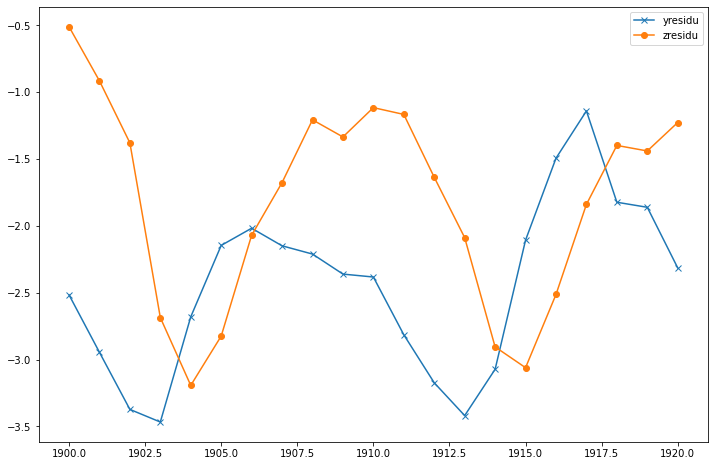

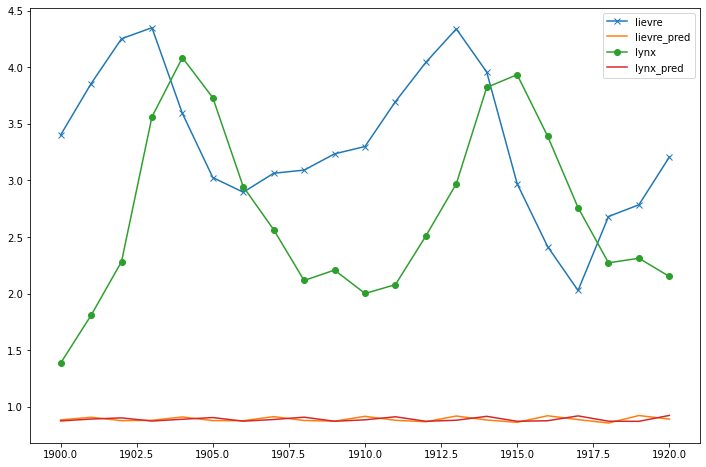

In [187]:
result = minimize(epsilon,x0,args=args,method="SLSQP",bounds= bound)
x = result['x']

temps,y,z = resolutionSystem1Euler(x[0],x[1],x[2],x[3],x[4],x[5],args[0],args[1])
dt = args[0]
ypred = y[[int(k/dt) for k in range(21)]]
zpred = z[[int(k/dt) for k in range(21)]]
yresidu = np.log(ypred)-np.log(args[2])
zresidu = np.log(zpred)-np.log(args[3])

plt.figure(figsize=(12,8), facecolor='white')
plt.plot(annee,yresidu,"-x", label = "yresidu")
plt.plot(annee,zresidu, "-o",label = "zresidu")
plt.legend()
plt.show()


plt.figure(figsize=(12,8), facecolor='white')
plt.plot(annee,np.log(args[2]),"-x", label = "lievre")
plt.plot(annee,np.log(ypred), label = "lievre_pred")
plt.plot(annee,np.log(args[3]), "-o",label = "lynx")
plt.plot(annee,np.log(zpred),label = "lynx_pred")
plt.legend()
plt.show()

In [184]:
## Test de plusieurs conditions initiales
x0 = [1.5,1.04,1.1,1.6,4,6]

for i in range(40):
  for j in range(6):
    x0[j]=np.random.uniform(bound[j][0],bound[j][1])
#   print(x0)
  result=minimize(epsilon,x0,args=args,method="SLSQP",bounds= bound)
  print(result['fun'])

215.74454414886074
215.74454430188814
215.74454414358718
215.7445441324073
215.74454409399098
215.74454412184497


/var/folders/5t/4vl766s17mn_xbr_cwlzgy9r0000gn/T/ipykernel_4879/1957544314.py:7: RuntimeWarning: invalid value encountered in log
  yresidu = np.log(ypred)-np.log(args[2])


215.7445456886498
nan
215.7445440737959
215.74454409294066
215.74454421791003
nan
215.7445442959358
215.7445440747698
215.7445443326248
215.74454421262308
215.74454420471943
215.74454415602455
215.74454427745883
215.74454446322585
215.74454438421714
215.74454437530034
215.74454445314927
215.74454408846825
215.74454407882166
215.7445440670457
215.74454404508327
215.74454410587668
215.74454405933565
215.74454405436225
nan
215.74454463498304
215.74454414792189
215.74454415814176
215.7445442271786
215.74454419498906
215.74454409505165
215.74454404883076
215.7445446526943
215.7445440659826


In [ ]:
least_squares(epsilon,x0,args=args,bounds= (min_bound,max_bound))

In [206]:
## Allure de la fonction objective
x = []
N_discret = 30
x.append(np.linspace(bound[0][0], bound[0][1], N_discret))
x.append(np.linspace(bound[1][0], bound[1][1], N_discret))
for j in range(4):
    x.append(np.random.uniform(bound[j][0],bound[j][1]))

X, Y = np.meshgrid(x[0], x[1])
func_objec = []
for i in range(N_discret):
    x_i = [x[0][i], x[1][i], x[2], x[3], x[4], x[5]]
    func_objec.append(epsilon(x_i, *args))


print(np.shape(X))

(30, 30)
